In [3]:
import xarray as xr
import numpy as np
import tools
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

scrip.so not found. Remapping function will not be available


# Create Observations for OSSE

Using the WMOP forecast as a nature run for our OSSE experiment we are going to prepare the sinthetic observations for Assimilation

- The period of the experiment is the same as the OSE HFradar assimilation experiments previosuly realized (20 September to 20 October 2014)

- WMOP forecast used as Nature run. For the period selected the model, by coincidence, was not restarted from and thus we have a continuos free run, as we liked to.  In the future using WMOP hindcast MERCATOR as NR may be considered

- Observations from real sources will be simulated by interpolating the NR field to the observqation points. Histogram of innovations (difference between virtual observation and model) should be regarded and compared against the innovations of the real observations 

- Virtual HF radar antennas in Denia will be simulated by supossing a virtual rdar footprint and considering the observations of the surface velocitu fields within it, considering also possible gaps in the coverage area
                                                                                                        

#### Define Paths to Observations and NR

In [4]:
obs_path = '/DATA/jhernandez/WMOP_ASSIM/Observations/HFR_all_nudging_Oct2014/'
nr_path = '/home/modelling/data/WMOP/WMOP_FORECAST/Outputs/FORECAST_CMEMS_RESTARTS/forecast_scratch/'

#### Load Observations

In [5]:
obsfile = glob(obs_path + '*obs')
obsfile.sort()

df = tools.read_obsfile(obsfile[0])

#### Get Altimetry Observations

In [6]:
strdate = '20140920'

# WMOP MDT
file_mdt = '/data/modelling/WMOP_ASSIM/Inputs/roms_WMOP_HINDCAST_synthetic_201505_201704_mean.nc'
ds_mdt = xr.open_dataset(file_mdt)

file_wmop = '{0}/roms_WMOP_FORECAST_{1}_his.nc'.format(nr_path, strdate)
ds_wmop = xr.open_dataset(file_wmop)

# Load Control Run (No Assim)
file_wmop2 = '/home/modelling/data/workdir_2/HFR_DA/HFR_NOASSIM_Oct2014/roms_WMOP_ASSIM_{0}_his.nc'.format(strdate)
ds_wmop2 = xr.open_dataset(file_wmop2)

# Subset Altimetry Observations
df_sla = df[df['var']=='h']


In [7]:
import scipy.interpolate as interp
from datetime import datetime 
from datetime import timedelta

In [8]:
t0 = datetime.now()

# Subset Observations
#df_sla2 = df_sla.iloc[0:300]

# Create empty array
sla_interp = np.array([])

for i in range(len(df_sla)):

    obs = df_sla.iloc[i]
    date_obs = datetime(obs['year'], obs['month'], obs['day'], obs['hour'], obs['minute'])
    strdate_obs = date_obs.strftime('%Y%m%d')
    
    # Load NR file to extract observations from
    file_wmop = '{0}/roms_WMOP_FORECAST_{1}_his.nc'.format(nr_path, strdate_obs)
    ds_wmop = xr.open_dataset(file_wmop)
    
    # Get time slot to extract obs from
    dt = np.diff(ds_wmop.ocean_time.values) / np.timedelta64(1, 'h')
    dt = int(np.unique(dt))
    idt = obs.hour // dt
    
    # Get SSH
    sla0 = ds_wmop.zeta[idt,:,:].values - ds_mdt.zeta[0,:,:].values
    sla0[np.isnan(sla0)] = 10000
    fz = interp.interp2d(ds_wmop.lon_rho[1,:].values, ds_wmop.lat_rho[:,1].values, sla0, kind='linear')
    
    sla1 = ds_wmop.zeta[idt+1,:,:].values - ds_mdt.zeta[0,:,:].values
    sla1[np.isnan(sla1)] = 10000
    fz1 = interp.interp2d(ds_wmop.lon_rho[1,:].values, ds_wmop.lat_rho[:,1].values, sla1, kind='linear')

    s0 = fz(obs.lon, obs.lat)
    s1 = fz(obs.lon, obs.lat)
    
    # ponderate sla obs with weights
    w1 = ( (obs.hour + obs.minute/60) / dt) - obs.hour//dt
    sla_interp = np.concatenate((sla_interp, w1*s1 + (1-w1)*s0))


df_sla['sla_interp'] =  sla_interp
df_sla[['val', 'sla_interp']]

tf = datetime.now()

print(' Tiempo total = {0}'.format((tf-t0).total_seconds()))

 Tiempo total = 88.759298


/DATA/jhernandez/Softs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
hour=8
dt=4
w1 = ( hour / dt) - hour//dt
print(hour//dt)
print(w1)

2
0.0


In [10]:
sla3 = df_sla['sla_interp'] + np.sqrt(df_sla['err'])* np.random.normal(0,1,len(df_sla['err']))

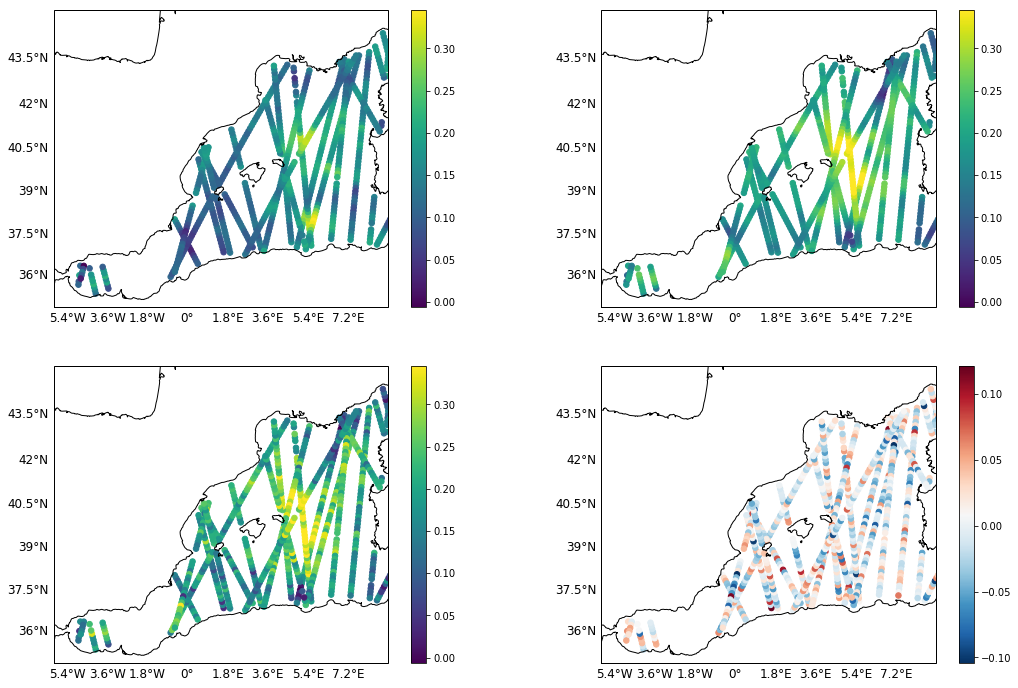

In [9]:
plt.figure(figsize=(18,12))

ax, gl = tools.make_map(continents=False, subplot_dim=221)
plt.scatter(df_sla['lon'], df_sla['lat'], 30, df_sla['val'], transform=gl.crs)
cb = plt.colorbar()

ax, gl = tools.make_map(continents=False, subplot_dim=222)
plt.scatter(df_sla['lon'], df_sla['lat'], 30, df_sla['sla_interp'], transform=gl.crs, vmin= cb.get_clim()[0], vmax = cb.get_clim()[1])
plt.colorbar()

ax, gl = tools.make_map(continents=False, subplot_dim=223)
plt.scatter(df_sla['lon'], df_sla['lat'], 30, sla3, transform=gl.crs, vmin= cb.get_clim()[0], vmax = cb.get_clim()[1])
plt.colorbar()

ax, gl = tools.make_map(continents=False, subplot_dim=224)
plt.scatter(df_sla['lon'], df_sla['lat'], 30, df_sla['sla_interp']-sla3, transform=gl.crs, cmap='RdBu_r')
plt.colorbar()

plt.show()

In [10]:
cb.get_clim()[0]

-0.006

In [14]:
pd.DataFrame(sla3).describe()#-df_sla['sla_interp']).describe()

,0
count,850.000000
mean,0.201556
std,0.071253
min,-0.054931
25%,0.155267
50%,0.198324
75%,0.245353
max,0.419897


### Comparison of real and sinthetic SLA observations

#### Description

In [12]:
print(df_sla[['val','sla_interp']].describe())
#df_sla[['val','sla_interp']].describe().to_latex()

              val  sla_interp
count  850.000000  850.000000
mean     0.151833    0.201343
std      0.052638    0.061220
min     -0.006000    0.020499
25%      0.113250    0.162346
50%      0.146000    0.199630
75%      0.185000    0.240432
max      0.345000    0.395084


#### Plot

In [12]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

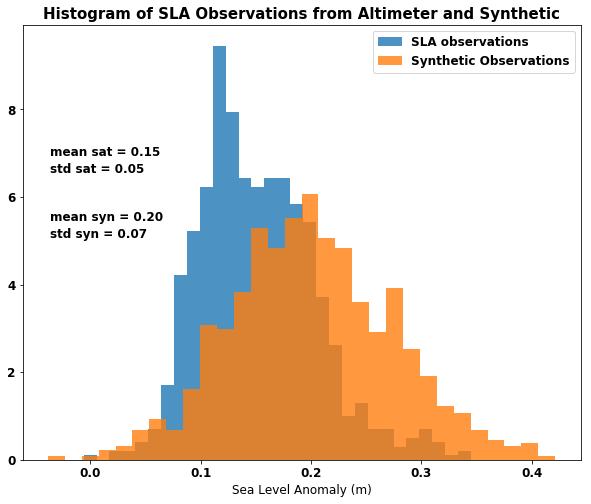

In [38]:
fig_sla_hist = plt.figure(figsize=(10,8))
ax = plt.subplot(111)

plt.hist(df_sla['val'], 30, density=True, alpha=0.8)
#plt.hist(df_sla['sla_interp'], 30, density=True, alpha=0.8)
plt.hist(sla3, 30, density=True, alpha=0.8)

plt.legend(['SLA observations', 'Synthetic Observations'])
plt.title('Histogram of SLA Observations from Altimeter and Synthetic', fontsize=15, fontweight='bold')
plt.xlabel('Sea Level Anomaly (m)')

plt.text(0.05, 0.7, 'mean sat = {0:0.2f}'.format(np.mean(df_sla['val'])), transform=ax.transAxes)
plt.text(0.05, 0.66, 'std sat = {0:0.2f}'.format(np.std(df_sla['val'])), transform=ax.transAxes)

plt.text(0.05, 0.55, 'mean syn = {0:0.2f}'.format(np.mean(sla3)), transform=ax.transAxes)
plt.text(0.05, 0.51, 'std syn = {0:0.2f}'.format(np.std(sla3)), transform=ax.transAxes)


plt.show()

In [39]:
fig_sla_hist.savefig('/home/jhernandez/Escritorio/OSSE_v2/histogram_sla_observations_OSSE_noise.png', dpi=250)

## Get SST Observations

In [15]:
df_sst = df[df['source']=='GHRSST_JPL'].reset_index(drop=True)

In [16]:
date = df_sst[['year', 'month', 'day', 'hour', 'minute']].drop_duplicates()
date = datetime(date['year'], date['month'], date['day'], date['hour'], date['minute'])
strdate = date.strftime('%Y%m%d')

In [17]:
t0 = datetime.now()

# Load NR file to extract observations from
file_wmop = '{0}/roms_WMOP_FORECAST_{1}_his.nc'.format(nr_path, strdate)
ds_wmop = xr.open_dataset(file_wmop)

# Get time slot to extract obs from
dt = np.diff(ds_wmop.ocean_time.values) / np.timedelta64(1, 'h')
dt = int(np.unique(dt))
hour = 9  # observation time desired
idt = hour // dt 

# Get SSH. Interpolate for two time steps according to weights 
sst0 = ds_wmop.temp[idt,-1,:,:].values
sst1 = ds_wmop.temp[idt+1,-1,:,:].values

# ponderate SST obs with weights
w1 = ( hour / dt) - idt
sst = w1*sst1 + (1-w1)*sst0

sst[np.isnan(sst)] = 10000
fz = interp.interp2d(ds_wmop.lon_rho[1,:].values, ds_wmop.lat_rho[:,1].values, sst, kind='linear')

sst_interp = [fz(df_sst.iloc[i].lon, df_sst.iloc[i].lat) for i in range(len(df_sst))]
sst_interp = np.array(sst_interp)


sst_interp[sst_interp>35] = np.nan


df_sst['sst_interp'] =  sst_interp
df_sst[['val', 'sst_interp']]

tf = datetime.now()

print(' Tiempo total = {0}'.format((tf-t0).total_seconds()))

 Tiempo total = 3.980105


In [18]:
sst3 = df_sst['sst_interp'] + np.sqrt(df_sst['err'])* np.random.normal(0,1,len(df_sst['err']))

### Plot SST Observations

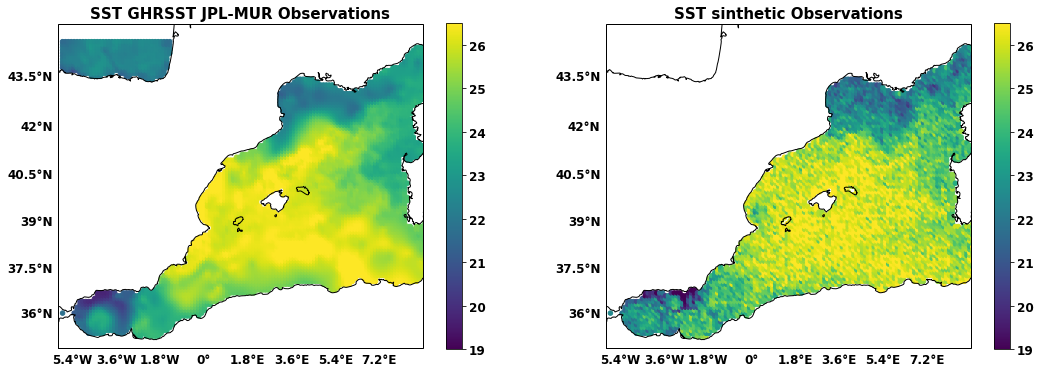

In [19]:
fig_sst = plt.figure(figsize=(18,6))

ax, gl = tools.make_map(continents=False, subplot_dim=121) 
plt.scatter(df_sst.lon, df_sst.lat, 20, df_sst.val, vmin=19, vmax=26.5, transform=gl.crs)
plt.colorbar()
plt.title('SST GHRSST JPL-MUR Observations', fontsize=15, fontweight='bold')

ax, gl = tools.make_map(continents=False, subplot_dim=122) 
plt.scatter(df_sst.lon, df_sst.lat, 20, sst3, vmin=19, vmax=26.5, transform=gl.crs)
plt.colorbar()
plt.title('SST sinthetic Observations', fontsize=15, fontweight='bold')

plt.show()

### Plot Histogram of Observations

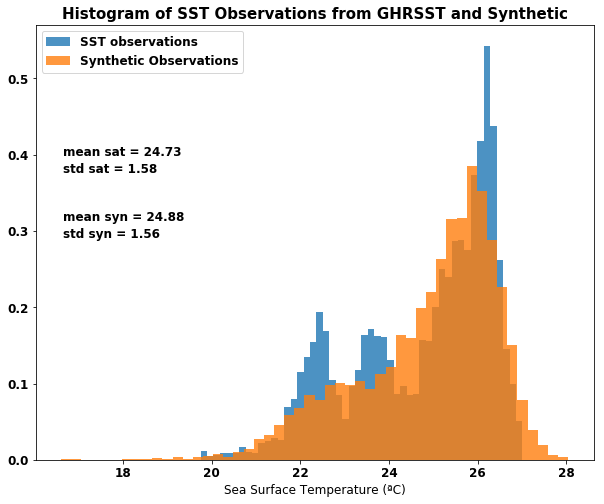

In [26]:
fig_sst_hist = plt.figure(figsize=(10,8))

ax = plt.subplot(111)

plt.hist(df_sst['val'], 50, density=True, alpha=0.8)
#plt.hist(df_sst['sst_interp'], 50, density=True, alpha=0.8)
plt.hist(sst3, 50, density=True, alpha=0.8)

plt.legend(['SST observations', 'Synthetic Observations'])
plt.title('Histogram of SST Observations from GHRSST and Synthetic', fontsize=15, fontweight='bold')
plt.xlabel('Sea Surface Temperature (ªC)')

plt.text(0.05, 0.7, 'mean sat = {0:0.2f}'.format(np.mean(df_sst['val'])), transform=ax.transAxes)
plt.text(0.05, 0.66, 'std sat = {0:0.2f}'.format(np.std(df_sst['val'])), transform=ax.transAxes)

#plt.text(0.05, 0.55, 'mean syn = {0:0.2f}'.format(np.mean(df_sst['sst_interp'])), transform=ax.transAxes)
#plt.text(0.05, 0.51, 'std syn = {0:0.2f}'.format(np.std(df_sst['sst_interp'])), transform=ax.transAxes)

plt.text(0.05, 0.55, 'mean syn = {0:0.2f}'.format(np.mean(sst3)), transform=ax.transAxes)
plt.text(0.05, 0.51, 'std syn = {0:0.2f}'.format(np.std(sst3)), transform=ax.transAxes)


plt.show()

In [40]:
fig_sst_hist.savefig('/home/jhernandez/Escritorio/OSSE_v2/histogram_sst_observations_OSSE_noise.png', dpi=250)

#### Describe statistics

In [ ]:
print(df_sst[['val','sst_interp']].describe())

In [ ]:
print('Lenght of ocean time = {0}.  time step of outputs = {1}h'.format(ds_wmop.ocean_time.shape[0], dt))


## Get HFR observations

In [28]:
df_uhfr = df[(df['source']=='HF_Radar') & (df['var']=='u')].reset_index(drop=True)
df_vhfr = df[(df['source']=='HF_Radar') & (df['var']=='v')].reset_index(drop=True)

In [29]:

# Interp U
u = ds_wmop.u[:,-1,:,:].mean(axis=0).values
u[np.isnan(u)] = 100000

fu = interp.interp2d(ds_wmop.lon_u[1,:].values, ds_wmop.lat_u[:,1].values, u, kind='linear')
u_interp = [fu(df_uhfr.iloc[i].lon, df_uhfr.iloc[i].lat) for i in range(len(df_uhfr))]
u_interp = np.array(u_interp)
u_interp[u_interp>1000] = np.nan
df_uhfr['u_interp'] = u_interp


# Interp V
v = ds_wmop.v[:,-1,:,:].mean(axis=0).values
v[np.isnan(v)] = 100000

fv = interp.interp2d(ds_wmop.lon_v[1,:].values, ds_wmop.lat_v[:,1].values, v, kind='linear')
v_interp = [fv(df_vhfr.iloc[i].lon, df_vhfr.iloc[i].lat) for i in range(len(df_vhfr))]
v_interp = np.array(v_interp)
v_interp[v_interp>1000] = np.nan
df_vhfr['v_interp'] = v_interp

/DATA/jhernandez/Softs/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


##### Interp Control Run (NOASSIM) to HF radar points

In [30]:
# Interp U
u = ds_wmop2.u[:,-1,:,:].mean(axis=0).values
u[np.isnan(u)] = 100000

fu = interp.interp2d(ds_wmop2.lon_u[1,:].values, ds_wmop2.lat_u[:,1].values, u, kind='linear')
u_interp = [fu(df_uhfr.iloc[i].lon, df_uhfr.iloc[i].lat) for i in range(len(df_uhfr))]
u_interp = np.array(u_interp)
u_interp[u_interp>1000] = np.nan
df_uhfr['u_interp2'] = u_interp


# Interp V
v = ds_wmop2.v[:,-1,:,:].mean(axis=0).values
v[np.isnan(v)] = 100000

fv = interp.interp2d(ds_wmop2.lon_v[1,:].values, ds_wmop2.lat_v[:,1].values, v, kind='linear')
v_interp = [fv(df_vhfr.iloc[i].lon, df_vhfr.iloc[i].lat) for i in range(len(df_vhfr))]
v_interp = np.array(v_interp)
v_interp[v_interp>1000] = np.nan
df_vhfr['v_interp2'] = v_interp

In [61]:
print(df_uhfr[['val','u_interp', 'u_interp2']].describe())
print('\n V statistics')
print(df_vhfr[['val','v_interp', 'v_interp2']].describe())

              val    u_interp   u_interp2
count  318.000000  317.000000  317.000000
mean     0.014853    0.033213    0.142470
std      0.039485    0.047415    0.100347
min     -0.106941   -0.048382   -0.031525
25%     -0.008696   -0.009415    0.053409
50%      0.023854    0.034578    0.124166
75%      0.041779    0.065316    0.221197
max      0.094194    0.155463    0.380393

 V statistics
              val    v_interp   v_interp2
count  318.000000  318.000000  318.000000
mean    -0.030916    0.039153    0.083192
std      0.058470    0.081414    0.053242
min     -0.258120   -0.141707   -0.039013
25%     -0.054840   -0.021357    0.051481
50%     -0.018604    0.038471    0.087433
75%      0.011924    0.108856    0.112613
max      0.055421    0.199166    0.272733


### Plot U - velocity

In [71]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

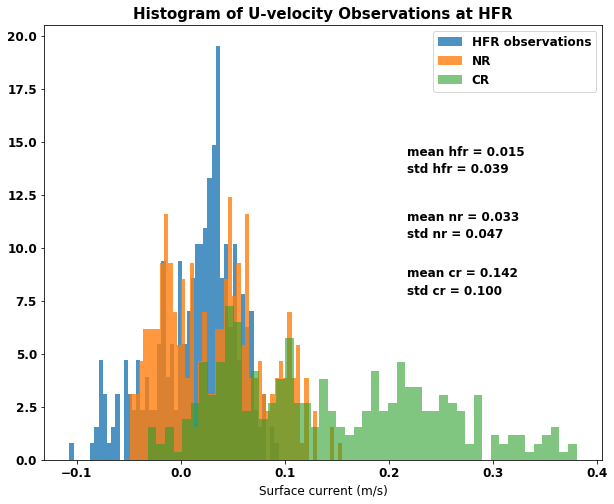

In [34]:
fig_uhfr_hist = plt.figure(figsize=(10,8))
ax = plt.subplot(111)

plt.hist(df_uhfr['val'], 50, density=True, alpha=0.8)
plt.hist(df_uhfr['u_interp'], 50, density=True, alpha=0.8)
plt.hist(df_uhfr['u_interp2'], 50, density=True, alpha=0.6)

plt.legend(['HFR observations', 'NR', 'CR'])
plt.title('Histogram of U-velocity Observations at HFR', fontsize=15, fontweight='bold')
plt.xlabel('Surface current (m/s)')

plt.text(0.65, 0.7, 'mean hfr = {0:0.3f}'.format(np.mean(df_uhfr['val'])), transform=ax.transAxes)
plt.text(0.65, 0.66, 'std hfr = {0:0.3f}'.format(np.std(df_uhfr['val'])), transform=ax.transAxes)

plt.text(0.65, 0.55, 'mean nr = {0:0.3f}'.format(np.mean(df_uhfr['u_interp'])), transform=ax.transAxes)
plt.text(0.65, 0.51, 'std nr = {0:0.3f}'.format(np.std(df_uhfr['u_interp'])), transform=ax.transAxes)

plt.text(0.65, 0.42, 'mean cr = {0:0.3f}'.format(np.mean(df_uhfr['u_interp2'])), transform=ax.transAxes)
plt.text(0.65, 0.38, 'std cr = {0:0.3f}'.format(np.std(df_uhfr['u_interp2'])), transform=ax.transAxes)

plt.show()

In [33]:
fig_uhfr_hist.savefig('/home/jhernandez/Escritorio/histogram_uhfr_observations_OSSE_nr_cr.png', dpi=250)

### Plot  V - velocity

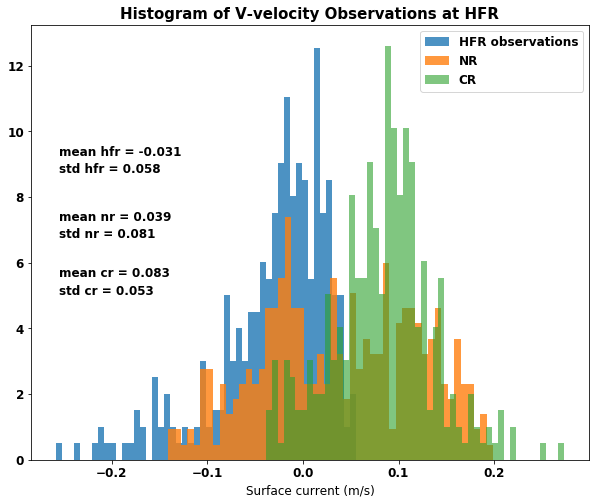

In [37]:
fig_vhfr_hist = plt.figure(figsize=(10,8))
ax = plt.subplot(111)

plt.hist(df_vhfr['val'], 50, density=True, alpha=0.8)
plt.hist(df_vhfr['v_interp'], 50, density=True, alpha=0.8)
plt.hist(df_vhfr['v_interp2'], 50, density=True, alpha=0.6)

plt.legend(['HFR observations', 'NR', 'CR'])
plt.title('Histogram of V-velocity Observations at HFR', fontsize=15, fontweight='bold')
plt.xlabel('Surface current (m/s)')

plt.text(0.05, 0.7, 'mean hfr = {0:0.3f}'.format(np.mean(df_vhfr['val'])), transform=ax.transAxes)
plt.text(0.05, 0.66, 'std hfr = {0:0.3f}'.format(np.std(df_vhfr['val'])), transform=ax.transAxes)

plt.text(0.05, 0.55, 'mean nr = {0:0.3f}'.format(np.mean(df_vhfr['v_interp'])), transform=ax.transAxes)
plt.text(0.05, 0.51, 'std nr = {0:0.3f}'.format(np.std(df_vhfr['v_interp'])), transform=ax.transAxes)

plt.text(0.05, 0.42, 'mean cr = {0:0.3f}'.format(np.mean(df_vhfr['v_interp2'])), transform=ax.transAxes)
plt.text(0.05, 0.38, 'std cr = {0:0.3f}'.format(np.std(df_vhfr['v_interp2'])), transform=ax.transAxes)

plt.show()

In [36]:
fig_vhfr_hist.savefig('/home/jhernandez/Escritorio/histogram_vhfr_observations_OSSE_nr_cr.png', dpi=250)

## Create HF radar Observations from virtual antennas in Denia

#### Load Shapefile

In [ ]:
import shapefile
from shapely.geometry import Point
from shapely.geometry import Polygon

In [ ]:
# Path to shapefile
shape_path = '/home/jhernandez/Escritorio/mygeodata/'
shape_file = glob(shape_path + '/*shp')
# Load Shapefile
shape = shapefile.Reader(shape_file[0])

In [ ]:
feature = shape.shapeRecords()[0]
first = feature.shape.__geo_interface__ 
coverage = Polygon(feature.shape.points)

### Plot coverage area Shapefile

In [ ]:
lon = [a[0]  for a in feature.shape.points]
lat = [a[1]  for a in feature.shape.points]

In [ ]:
plt.figure(figsize=(10,10))

ax, gl = tools.make_map(continents=False, limits=[-1.5, 3.6, 38, 40.5])

for i in range(len(feature.shape.points)):
    plt.plot(lon, lat,'.', transform=gl.crs)
    
plt.title('HF radar coverage Area', fontweight='bold', fontsize=15)

plt.show()

#### Create mask

In [ ]:
# Load WMOP file to extract Longitude and Latitude from
file_wmop = '{0}/roms_WMOP_FORECAST_{1}_his.nc'.format(nr_path, strdate)
ds_wmop = xr.open_dataset(file_wmop)


In [ ]:
# Get index of bounding box limits
id1 = np.abs(ds_wmop.lon_u[1,:].values-0).argmin()
id2 = np.abs(ds_wmop.lon_u[1,:].values-1.4).argmin()
id3 = np.abs(ds_wmop.lat_u[:,1].values-38.3).argmin()
id4 = np.abs(ds_wmop.lat_u[:,1].values-39.2).argmin()

In [ ]:
# Extract longitude and latitude for U and V for the area
lonu = ds_wmop.lon_u[id3:id4,id1:id2].values.reshape(-1)
latu = ds_wmop.lat_u[id3:id4,id1:id2].values.reshape(-1)
lonv = ds_wmop.lon_v[id3:id4,id1:id2].values.reshape(-1)
latv = ds_wmop.lat_v[id3:id4,id1:id2].values.reshape(-1)

In [ ]:
mask_u = np.zeros(ds_wmop.lon_u.values.shape)
mask_v = np.zeros(ds_wmop.lon_v.values.shape)

# See  if point are contained within the polygon defined
mask_u1 = [coverage.contains(Point(lonu[i], latu[i])) for i in range(len(lonu))]
mask_v1 = [coverage.contains(Point(lonv[i], latv[i])) for i in range(len(lonv))] 
# Reshape to 2D
mask_u1 = np.array(mask_u1).reshape(id4-id3, id2-id1)
mask_v1 = np.array(mask_v1).reshape(id4-id3, id2-id1)

# Mask the whole domain
mask_u[id3:id4,id1:id2] = mask_u1
mask_v[id3:id4,id1:id2] = mask_v1

# Mask with NaNs
mask_u[mask_u==0] = np.nan
mask_v[mask_v==0] = np.nan

In [ ]:
plt.figure(figsize=(12,6))

ax, gl = tools.make_map(continents=True, limits=[-1.5, 3.6, 38, 40.5])
plt.pcolormesh(ds_wmop.lon_u, ds_wmop.lat_u, mask_u, transform=gl.crs)

plt.show()

### Get Velocity Observations within the coverage area

In [ ]:
# Get velocity fields
u = ds_wmop.u[:,-1,:,:].mean(axis=0).values
v = ds_wmop.v[:,-1,:,:].mean(axis=0).values
# Apply mask
u = u*mask_u
v = v*mask_v

# Reshape as array
u_1d = u[np.isnan(u)==0]
lon_u = ds_wmop.lon_u.values[np.isnan(u)==0]
lat_u = ds_wmop.lat_u.values[np.isnan(u)==0]

v_1d = v[np.isnan(v)==0]
lon_v = ds_wmop.lon_v.values[np.isnan(v)==0]
lat_v = ds_wmop.lat_v.values[np.isnan(v)==0]


In [ ]:
import random

In [ ]:
# Extract randomly a certain number of elements
idu = list(range(len(u_1d)))
idv = list(range(len(u_1d)))
random.shuffle(idu)
random.shuffle(idv)
# number of elements to extract
nb = len(u_1d)//15

# Extract randomly values for validation
u1 = u_1d[idu[1:nb]]
v1 = v_1d[idv[1:nb]]
lonu = lon_u[idu[1:nb]]
lonv = lon_v[idv[1:nb]]
latu = lat_u[idu[1:nb]]
latv = lat_v[idv[1:nb]]

u_1d[idu[1:nb]] = np.nan
v_1d[idv[1:nb]] = np.nan

# Get only valid observations
lon_u = lon_u[np.isnan(u_1d)==0]
lon_v = lon_v[np.isnan(v_1d)==0]
lat_u = lat_u[np.isnan(u_1d)==0]
lat_v = lat_v[np.isnan(v_1d)==0]
v_1d = v_1d[np.isnan(v_1d)==0]
u_1d = u_1d[np.isnan(u_1d)==0]

In [ ]:
plt.figure(figsize=(12,6))

ax, gl = tools.make_map(continents=True, limits=[-1.5, 3.6, 38, 40.5])
plt.scatter(lon_u, lat_u, 5,  u_1d, transform=gl.crs)

plt.show()

In [ ]:
plt.figure(figsize=(12,6))

ax, gl = tools.make_map(continents=True, limits=[-1.5, 3.6, 38, 40.5])
plt.scatter(lonu, latu, 10,  u1, transform=gl.crs)

plt.show()

### Create DataFrame of subset for Validation

In [ ]:
du_val = {'var': 'u', 'source': 'HF_Radar', 'year': date.year, 'month': date.month, 'day': date.day,'hour': date.hour,
        'minute': date.minute,'lon': lonu, 'lat':latu, 'depth': 0.0, 'val':u1, 'err': 0.01, 'rep': 1}
dv_val = {'var': 'v', 'source': 'HF_Radar', 'year': date.year, 'month': date.month, 'day': date.day,'hour': date.hour,
        'minute': date.minute,'lon': lonv, 'lat':latv, 'depth': 0.0, 'val':v1, 'err': 0.01, 'rep': 1}

dfu_val = pd.DataFrame(data=du_val)
dfv_val = pd.DataFrame(data=dv_val)

df_val = pd.concat([dfu_val, dfv_val])

### Create New DataFrame of Sinthetic Observations

In [ ]:
du_new = {'var': 'u', 'source': 'HF_Radar', 'year': date.year, 'month': date.month, 'day': date.day,'hour': date.hour,
        'minute': date.minute,'lon': lon_u, 'lat':lat_u, 'depth': 0.0, 'val':u_1d, 'err': 0.01, 'rep': 1}
dv_new = {'var': 'v', 'source': 'HF_Radar', 'year': date.year, 'month': date.month, 'day': date.day,'hour': date.hour,
        'minute': date.minute,'lon': lon_v, 'lat':lat_v, 'depth': 0.0, 'val':v_1d, 'err': 0.01, 'rep': 1}

dfu_new = pd.DataFrame(data=du_new)
dfv_new = pd.DataFrame(data=dv_new)

df_hfr_new = pd.concat([dfu_new, dfv_new])

In [ ]:
df_val

In [ ]:
save_path = '/DATA/jhernandez/WMOP_ASSIM/Observations/HFR_OSSE/'
output_file = '{0}assim_obs_HFR_all_channel_{1}.obs'.format(save_path, strdate)
output_file_val = '{0}assim_obs_HFR_validation_{1}.obs'.format(save_path, strdate)

In [ ]:
output_file

In [ ]:
df_val.to_csv(output_file_val, header=None, sep=' ', index=False,  float_format='%.6f')
df_hfr_new.to_csv(output_file, header=None, sep=' ', index=False,  float_format='%.6f')

In [ ]:
date + timedelta(days=3)